# Introdução #

O trabalho a seguir tem como objetivo detalhar todos os procedimentos adotados para a submissão dos dados de treino no *Kaggle*. Ao longo desse *notebook*, serão discutidos o código, raciocínio e técnicas utilizadas para as manipulações dos dados disponibilizados em <https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data>.

Para linguagem de programação, ***Python*** foi escolhida pela vasta quantidade de bibliotecas *open source* disponíveis, destacando-se entre elas as que são voltadas para *data science*. Por trás do *python*, foi utilizado o gerenciador de pacotes ***Anaconda***, pela facilidade que o mesmo oferece na separação de ambientes de desenvolvimento e na instalação de dependências.

Em se tratando da manipulação dos dados, foram usadas as bibliotecas abaixo:
* **Numpy:** Oferece funcionalidades de manipulação de vetores, matrizes e transformações algébricas
* **Pandas:** Disponibiliza uma abstração em torno dos *Dataframes*, assim como funcionalidades de manipulação, filtro e concatenação dos mesmos
* **MatPlotLib:** Disponibilza funções de gráfico para visualização dos dados
* **Seaborn:** Abstração da *matplotlib*, com funções gráficas com uma abordagem mais estatística e orientada a *Dataframes*
* **sklearn:** Expõe modelos de regressão, treinamento e predição dos dados, orientados a *Dataframes*
* **scipy:** Oferece funções estatísticas para transformações
* **df_helper:** Implementada para o trabalho, oferece abstrações em torno da lib do *Pandas* para facilitar a manipulação dos *Dataframes*

# Objetivo #

O objetivo do trabalho é prever o preço de venda das casas de Ames, Iowa, com o conjunto de dados disponibilzados. Espera-se que, baseado nas *features* disponíveis, seja feito um pré-processamento dos dados, tratamento e predição dos preços das casas a partir conjunto de entrada. O resultado de saída deve ser submetido ao site do *Kaggle*, onde será feita uma validação e colocação no *ranking*, junto com outros competidores.

# Construção do Algoritmo #

### Importação das dependências ###

Como dito anteriormente, abaixo foram importadas as dependências para a implementação do código:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
from scipy import stats
from scipy.stats import norm, skew
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import df_helper as dh

### Carregamento dos dados ###
Com o auxílio do *Pandas*, carregam-se os dados de treino e, em seguida, separa-se a coluna de **Id** pela mesma ser desnecessária no processamento e predição dos dados:

In [2]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

train = pd.read_csv('.\\data\\train.csv')
test = pd.read_csv('.\\data\\test.csv')

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Mostrando forma do conjunto de dados
print("\nLinhas x Colunas para o conjunto de treino : {} ".format(train.shape)) 
print("Linhas x Colunas para o conjunto de teste : {}\n ".format(test.shape))


Linhas x Colunas para o conjunto de treino : (1460, 80) 
Linhas x Colunas para o conjunto de teste : (1459, 79)
 


### Análise das *features* ###

Abaixo, pode-se observar o mapa de correlação para análise do impacto de cada *feature* no *SalePrice* (variável a ser prevista), usando os dados de treino:

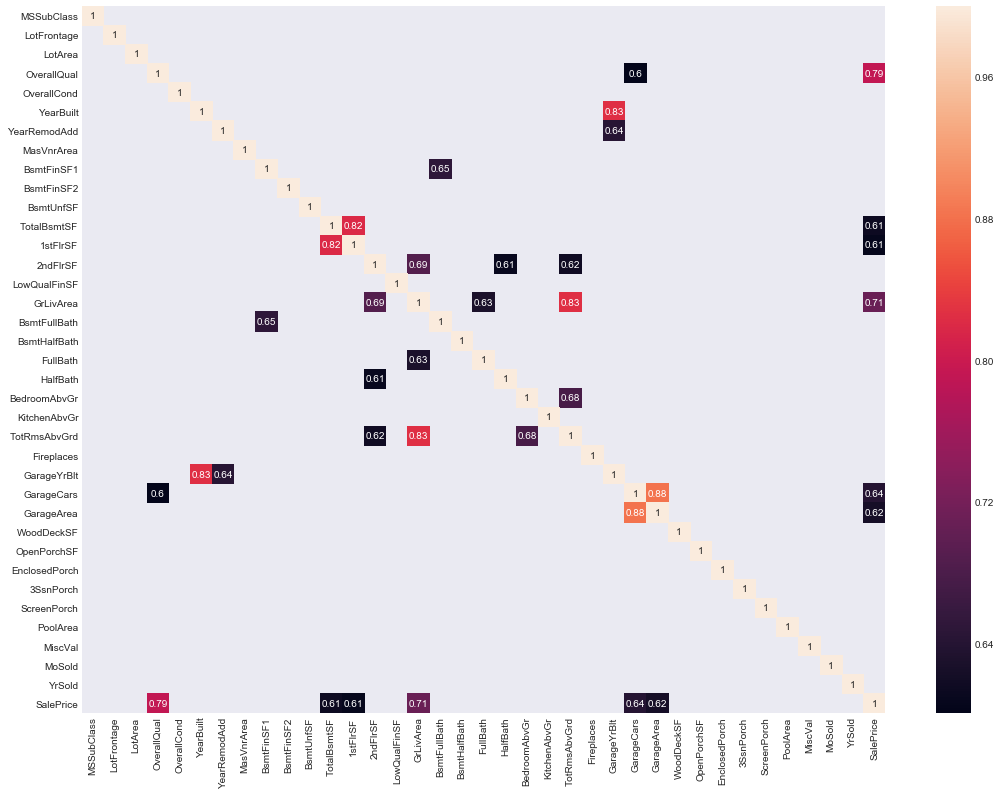

In [3]:
correlation_matrix = train.corr()
correlation_matrix = correlation_matrix[correlation_matrix > 0.6]
f, ax = plt.subplots(figsize=(18, 13))
sns.heatmap(correlation_matrix, annot=True);

Destacando as *features* com correlação maior que 0.7, observando o tipo dos dados e mostrando a relação entre elas e a variável a ser prevista:

Tipo da variável do conjunto OverallQual: int64
Tipo da variável do conjunto GrLivArea: int64


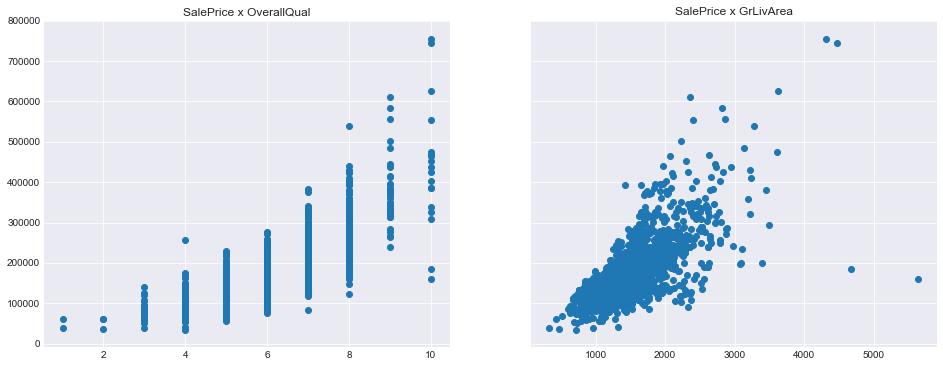

In [4]:
print("Tipo da variável do conjunto OverallQual: {}".format(train['OverallQual'].dtype))
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True,figsize=(16,6))
ax1.scatter(x = train['OverallQual'], y = train['SalePrice'])
ax1.set_title('SalePrice x OverallQual')

print("Tipo da variável do conjunto GrLivArea: {}".format(train['GrLivArea'].dtype))
ax2.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax2.set_title('SalePrice x GrLivArea')
plt.show()

Numa análise mais detalhada, observa-se que, apesar do tipo dos dados de ***OverallQual*** serem do tipo ***int64***, ela é praticamente categórica e poderia ser analisada como uma ***string***. Dessa maneira, escolhemos a ***GrLivArea*** para a remoção dos ***outliers*** dos dados de treino.

### Tratamento dos *outliers* ###

Observando os dados de ***SalePrice x GrLivArea***, nota-se a presença de dois dados com uma área desproporcional ao preço real. Removendo esses dados do conjunto:

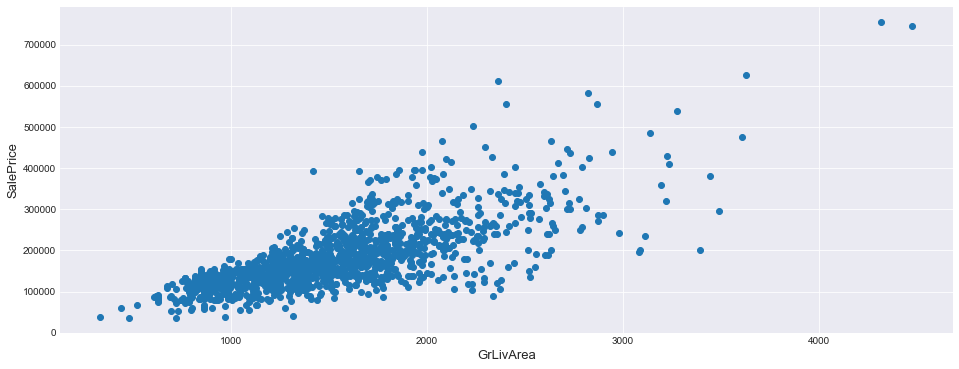

In [9]:
# Removendo outliers
train = dh.remove_outliers(train)
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()